# PySpark assignment

PySpark setup

In [1]:
__author__      = "DAMIAN Maleno, NEREA Izcue, PABLO Alonso "
__credits__     = ["Damian Maleno", "Nerea Izcue", "Pablo Alonso"]
__version__     = "1.0"
__email__       = ["100484916@alumnos.uc3m.es","100492040@alumnos.uc3m.es","100483840@alumnos.uc3m.es"]
__status__      = "In dev"

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
# JUST RUN THIS ONCE
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

# # Con esto lo que hacemos es iniciar la aplicación en el notebook
# conf = SparkConf().set('spark.ui.port', '4050')
# # Creamos el contexto de spark
# sc = SparkContext(conf=conf)
conf = SparkConf().setAll([('spark.executor.memory', '1g'), \
                                        ('spark.app.name', 'Spark Updated Conf'), \
                                        ('spark.executor.cores', '1'), \
                                        ('spark.cores.max', '2')]) # cambiar este para pasar a dos cores '1' -> '2'
# Creamos la sesión de spark
spark = SparkSession.builder.master('local[*]').getOrCreate()
# Local[*] is the ressource manager, with the brackets we specify how many cores we want (the max number of parallel ask we want to execute)
# * means everything, all the available ressources, we could switch that for yarn, or an URI (location of a spark installation)

spark

## CSV read: data extraction and cleansing
The first step is reading the dataset called 'tripdata_2017-01.csv'. For doing so, we give the format (in our case .csv) and set the different options.

In [6]:
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017-01.csv")

In [7]:
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

We calculate the number of rows of the dataframe.

In [8]:
df.count()

971010

In [9]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



We remove the rows with null values.

In [10]:
df_no_null = df.na.drop()
type(df.na)
df.count()

971010

Let's start **cleaning** the data. We have some wrong data that we must remove before starting the assignment. For example, it makes no sense to have trips that starts and end at the same time.

In [11]:
# Remove rows where time_start = time_end
df_correct_times = df_no_null.where(df_no_null['tpep_pickup_datetime'] != df_no_null['tpep_dropoff_datetime'])
df_correct_times.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

Also, we remove the rows with distance=0.

In [12]:
df_correct_distance = df_correct_times.where(df_correct_times['trip_distance'] != 0)
df_correct_distance.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

We also remove the rows that have trips without passengers, so we don't keep them.

In [13]:
df_correct_passengers = df_correct_distance.where(df_correct_distance['passenger_count'] != 0)
df_correct_passengers.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

Finally, we are going to **remove the outliers** of the dataframe. We have done a descriptive analysis of the variables of the dataframe values on **R** to discover the different outliers. To get a dataframe free of outliers we implement a ***spark.sql query***  as shown:

In [14]:
# SQL querys are done over dataframes not rdd
df_correct_passengers.createOrReplaceTempView('trips')
# Remove outliers
# Remove trips over 100 miles, tips over 100 dollars and total_amount over 10000
df_outliers = spark.sql('SELECT * FROM trips WHERE trip_distance < 100 OR tip_amount < 100 OR total_amount < 600 OR total_amount > 0;')
type(df_outliers)
df_outliers.count()

964710

Now, we **create new columns** that we will use on the future. First, we calculate the **time of the trip** as the difference between the time in which the trip started and the time the trip ended. We save this information in a **new column** called **ride_time**.

In [15]:
from pyspark.sql.functions import *
df_ride_time = df_outliers.withColumn('ride_time', unix_timestamp(df_correct_passengers['tpep_dropoff_datetime'])/60 - unix_timestamp(df_correct_passengers['tpep_pickup_datetime'])/60)
df_ride_time.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|         ride_time|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|     

Another new column, called **pick_hour**, is the **hour** in which the trip started (we are only interesting in the integer value of the hours).

In [16]:
df_ride_hour = df_ride_time.withColumn('pick_hour', hour(df_ride_time['tpep_pickup_datetime']))
df_ride_hour.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|         ride_time|pick_hour|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+---------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0

In the same way, we compute **the day of the week** (from sunday to sameday) in which the trip started (0 is sunday, monday is 1...) in **pick_day**.

In [17]:
# Add column with day of pick up
df_ride_day = df_ride_hour.withColumn('pick_day', dayofweek(df_ride_hour['tpep_pickup_datetime']))
df_ride_day.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+---------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|         ride_time|pick_hour|pick_day|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------------------+---------+--------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|  

# STUDIES

### **QUERY 1**- Average speed of the taxis in terms of the hours

In [18]:
import time
import pandas as pd
import matplotlib.pyplot as plt
data = df_ride_day.count()
#data is the amount of data processed

For this query we have generated different rdds. First, we picked only the columns that have a role on this query and save it in *rdd_avg_speed*. After that, we created a *rdd2* with a **map** as a tuple with pick_hour as **key** and we calculate the speed of each row (trip_distance/ride_time) in km/h (we had it in miles per seconds), saving it as the **value**.

So we only had to calculate **the mean**, to achieve it we first sum the values grouped by the key (hours) with a **reducebyKey** and we sort it with a **sortBy** to have the hours in the correct order. In addition we count the number of rows for each hour with a **countByKey**.

Finally, we save in a list *avg_speed*, the average speed of each hour to plot the barplot as the final output.

Elapsed execution avg speed per hours:  14.267643213272095  s
Amount of data processed:  964710  rows
Processing speed:  67615.23158236843  rows/s


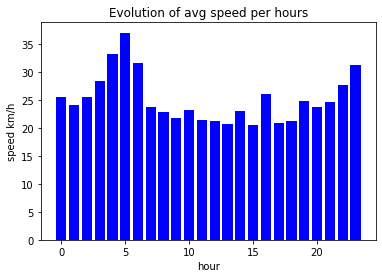

In [27]:
t_stamp = time.time()
rdd_avg_speed = df_ride_day.select(['pick_hour','trip_distance','ride_time']).rdd
# Speed to kph
rdd2 = rdd_avg_speed.map(lambda x: (x[0],( (x[1]*1.609) / (x[2]/60) )))
list_speed = rdd2.reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[0]).collect()
dict_key_count = rdd2.countByKey()
avg_speed = []
for i in list_speed:
  avg_speed.append((i[0], i[1] / dict_key_count[i[0]] ))
elapsed_time = time.time() - t_stamp
print("Elapsed execution avg speed per hours: ",elapsed_time," s")
print("Amount of data processed: ",data," rows")
print("Processing speed: ",(data/elapsed_time)," rows/s")
x = list(zip(*avg_speed))
plt.bar(x[0],x[1],color= 'b')
plt.xlabel('hour')
plt.ylabel('speed km/h')
plt.title('Evolution of avg speed per hours')
plt.show()

### **QUERY 2** - Most common trip

For this query, we are interesting in the pick-up location and the drop-off location. The idea is to create a rdd with the couple (*'PULocationID','DOLocationID'*) as the **key** and the number of times it is repeated as the **value** (initially is 1). To obtain this rdd we use a **map** which is later **grouped by key** and counted with the **mapValues()**. Finally, we sort it to get **the 5 more common trips.**

Elapsed execution most common trip:  7.383286237716675  s
Amount of data processed:  964710  rows
Processing speed:  130661.33005542832  rows/s
[((264, 264), 14501), ((237, 236), 3430), ((236, 236), 3129), ((236, 237), 3010), ((230, 246), 2943), ((79, 79), 2827)]


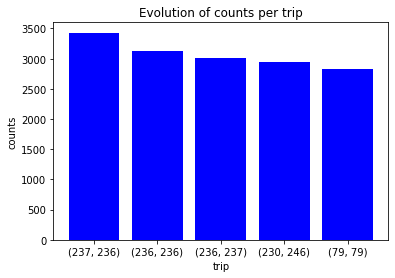

In [29]:
t_stamp = time.time()
rdd_trip = df_ride_day.select(['PULocationID','DOLocationID']).rdd
rdd_trip_tuple = rdd_trip.map(lambda x: ((x[0],x[1]),1)).groupByKey().mapValues(len).sortBy(lambda x: x[1], ascending= False).take(6)
elapsed_time = time.time() - t_stamp
print("Elapsed execution most common trip: ",elapsed_time," s")
print("Amount of data processed: ",data," rows")
print("Processing speed: ",(data/elapsed_time)," rows/s")
print(rdd_trip_tuple)
y = rdd_trip_tuple[1:]
x = list(zip(*y))
plt.bar([str(x[0][i]) for i in range(len(x[0]))],x[1],color= 'b')
plt.xlabel('trip')
plt.ylabel('counts')
plt.title('Evolution of counts per trip')
plt.show()

Then, the **most common trip** is the one with origin and destination the ID 264. Taking a look to the documentation we have that 264 correspond with the location *Unknown*, this is the reason why we have to descart it. The next 3 most common trips are related to the IDs 236 and 237 which are the "Manhattan Upper East Side North" and "Manhattan Upper East Side South". This makes sense as the **Upper East Side** is one of the most famous neighborhoods of Manhattan (and the richest one). Another common trips are "Manhattan 
, Times Squares/Theatre District" (ID 230) and "Manhattan, West Chelsea, Hudson Yards" (ID 246). 

### **QUERY 3** - Financial records

In the last query, we are going to find the average tip for the trips with the aeroport as destination, grouped by the number of passengers. This way, we want to see if the trips with more clients have greater tips, specially for the aeroport, which is one of the main services for a taxi driver and is related with longer distance. 

We will implement this query in the three Spark's API (rdd, direct sql and dataframe).

---



**RDD IMPLEMENTATION**

Let's start with the **RDDs.** Firstly, we **filter by** the JFK aeroport destination which is the ID 132. Hence, we keep only the rows with "DOLocationID"=132. After that, get two different rdds; the *rdd_key_count* which is the result of **mapping** with the number of passengers as **key** and the tip amount as **value** and **counted it by** key. And the *rdd_financial* which is the **sum of** the values **reduced by key** and **sorted**.

Then, we only have to calculate the **average tip** for each number of passengers from the two rdds we have computed before. Saving all this information in the list *avg_tip*. The output is the graphic result in a **barplot** and the list

Elapsed execution financial records:  23.441539764404297  s
Amount of data processed:  964710  rows
Processing speed:  41153.86658451937  rows/s
[(1, 5.975673758865221), (2, 5.590848484848492), (3, 5.040680473372778), (4, 4.41), (5, 5.953035230352302), (6, 5.5054940711462415)]


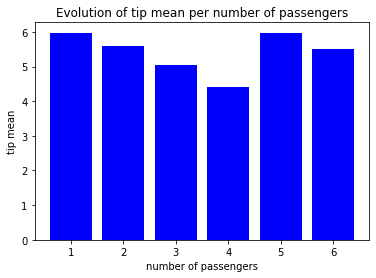

In [30]:
t_stamp = time.time()
rdd_financial_records = df_ride_day.select(['passenger_count','tip_amount','DOLocationID']).rdd
rdd_filtered = rdd_financial_records.filter(lambda x: x[2] == 132)
rdd_key_count = rdd_filtered.map(lambda x: (x[0],x[1])).sortByKey().countByKey() #It is a dictionary
rdd_financial = rdd_filtered.map(lambda x: (x[0],x[1])).reduceByKey(lambda x,y: x+y).sortByKey().collect()
avg_tip = []
for i in range(len(rdd_financial)):
  avg_tip.append((rdd_financial[i][0], rdd_financial[i][1]/rdd_key_count[i+1])) 
elapsed_time = time.time() - t_stamp
print("Elapsed execution financial records: ",elapsed_time," s")
print("Amount of data processed: ",data," rows")
print("Processing speed: ",(data/elapsed_time)," rows/s")
print(avg_tip)
x = list(zip(*avg_tip))
plt.bar(x[0],x[1],color= 'b')
plt.xlabel('number of passengers')
plt.ylabel('tip mean')
plt.title('Evolution of tip mean per number of passengers')
plt.show()

**SQL IMPLEMENTATION**

Now, we implement the query with the direct SQL API, which is not necessary to  explain due to it's simplicity.

In [33]:
t_stamp = time.time()
df_financial_records = df_ride_day.select(['passenger_count','tip_amount','DOLocationID'])
df_financial_records.createOrReplaceTempView('tips')
df_tips = spark.sql('SELECT passenger_count, avg(tip_amount) from tips where DOLocationID == 132 group by passenger_count order by 1;')
df_tips.show()
elapsed_time = time.time() - t_stamp
print("Elapsed execution financial records: ",elapsed_time," s")
print("Amount of data processed: ",data," rows")
print("Processing speed: ",(data/elapsed_time)," rows/s")

+---------------+------------------+
|passenger_count|   avg(tip_amount)|
+---------------+------------------+
|              1| 5.975673758865221|
|              2| 5.590848484848492|
|              3| 5.040680473372778|
|              4|              4.41|
|              5| 5.953035230352302|
|              6|5.5054940711462415|
+---------------+------------------+

Elapsed execution financial records:  4.234920501708984  s
Amount of data processed:  964710  rows
Processing speed:  227798.84524649172  rows/s


In [23]:
df_tips.toPandas()

,passenger_count,avg(tip_amount)
0,1,5.975674
1,2,5.590848
2,3,5.040680
3,4,4.410000
4,5,5.953035
5,6,5.505494


**DF IMPLEMENTATION**

Finally, we proccede with the **Dataframe implementation**. Similarly to the other query, we first **filter by** the ID location of the airport. Here we have some direct function that do the task straigh-forward. The idea, again, is to **group by** number of passengers and apply the **mean agreggation function** which should be sorted.

In [34]:
from pyspark.sql import functions as F
t_stamp = time.time()
df_financial_records = df_ride_day.select(['passenger_count','tip_amount','DOLocationID'])
df_groups_tips = df_financial_records.filter('DOLocationID == 132').groupBy('passenger_count').agg(F.mean('tip_amount')).sort('passenger_count')
df_groups_tips.show()
elapsed_time = time.time() - t_stamp
print("Elapsed execution financial records: ",elapsed_time," s")
print("Amount of data processed: ",data," rows")
print("Processing speed: ",(data/elapsed_time)," rows/s")

+---------------+------------------+
|passenger_count|   avg(tip_amount)|
+---------------+------------------+
|              1| 5.975673758865221|
|              2| 5.590848484848492|
|              3| 5.040680473372778|
|              4|              4.41|
|              5| 5.953035230352302|
|              6|5.5054940711462415|
+---------------+------------------+

Elapsed execution financial records:  3.2394566535949707  s
Amount of data processed:  964710  rows
Processing speed:  297799.94090349006  rows/s


In [25]:
df_groups_tips.toPandas()

,passenger_count,avg(tip_amount)
0,1,5.975674
1,2,5.590848
2,3,5.040680
3,4,4.410000
4,5,5.953035
5,6,5.505494


As expected, the fastest API's spark is **dataframe**, followed by **SQL** and finally **RDDs**. First, let's define what means each of these terms and explain why the previous statement is true.

*   **RDD** is a distributed collection of data elements spread across many machines in the cluster. RDDs are a set of Java or Scala objects representing data. 
*   **DataFrame** is a distributed collection of data organized into named columns. It is conceptually equal to a table in a relational database.

*   **DataSet (SQL)** is an extension of DataFrame API that provides the functionality of – type-safe, object-oriented programming interface of the RDD API and performance benefits of the Catalyst query optimizer and off heap storage mechanism of a DataFrame API.


The **RDDs** are defined as the distributed collection of the data elements without any schema. The **Dataset (SQL)** is an extension of the Dataframe with more added features like type-safety and object-oriented interface. The **Dataframes** is defined as the distributed collection organized into named columns.

The **Dataframes** provide API quickly to perform aggregation operations. The **RDDs** are slower than both the **Dataframes** and the **Datasets (SQL)** to perform simple functions like data grouping. The **Dataset (SQL)** is faster than the **RDDs** but is a bit slower than **Dataframes**. Hence, it performs aggregation faster than **RDDs** and the **Dataset (SQL)**.



***Table comparing execution times with 1 core vs. 2 cores***

| Query       | Time (1 core) | Time (2 cores) | Speed-Up |
|-------------|---------------|----------------|----------|
| Query 1     | 21.511 s      | 14.267 s       | 1.507    |
| Query 2     | 10.861 s      | 7.383 s        | 1.471    |
| Query 3 RDD | 39.267 s      | 23.441 s       | 1.675    |
| Query 3 SQL | 5.604 s       | 4.235 s        | 1.323    |
| Query 3 DF  | 5.242 s       | 3.239 s        | 1.618    |

As we can see from the previous table, when we execute our PySpark application with 2 cores instead of 1 core, the execution times are reduced. Therefore, we can affirm that Spark's API takes advantage of multicore computation.
It would be interesting to test Spark's API in another environment with a greater number of cores, and analyse how the problem scales when more hardware is used to solve it.